In [1]:
import numpy as np
import math
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
%matplotlib notebook

1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



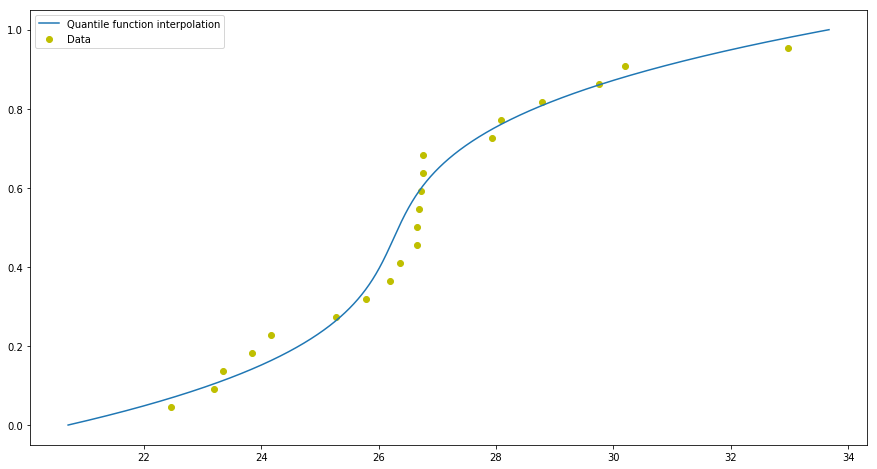

In [7]:
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]

cprob = (np.arange(years_nb) + 1)/(years_nb + 1)
sorted_max_speeds = np.sort(max_speeds)

quantile_func = UnivariateSpline(cprob, sorted_max_speeds)

nprob = np.linspace(0, 1, 1000)
fifty_prob = 1. - 0.02

fifty_wind = quantile_func(fifty_prob)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
ax.scatter(sorted_max_speeds, cprob, color = 'y', label = 'Data')
ax.plot(quantile_func(nprob), nprob, label = 'Quantile function interpolation')
ax.legend(loc='best')
plt.show()

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

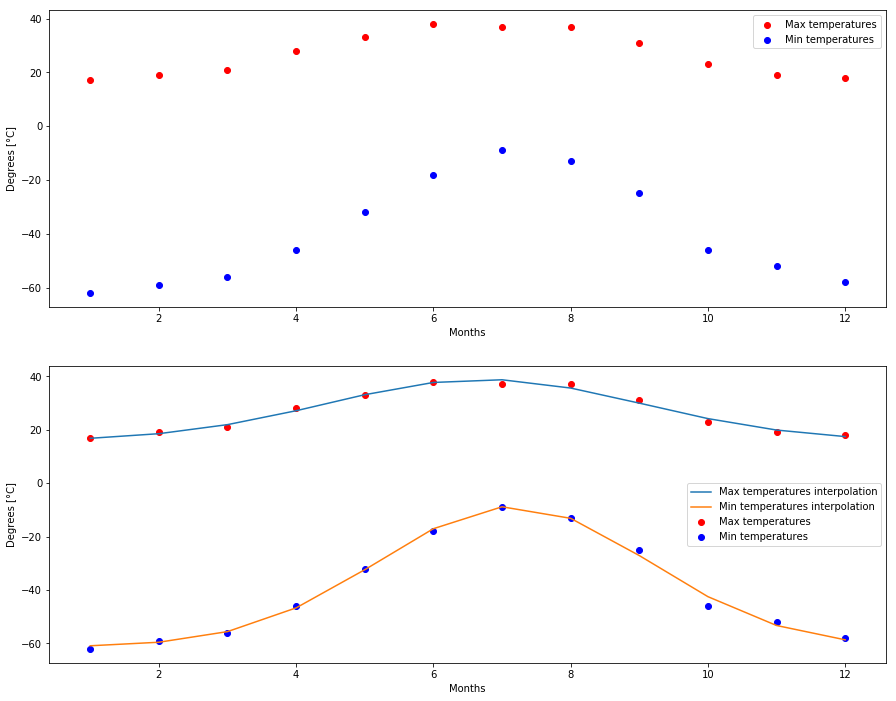

The parameters for the max temperatures interpolation are
 [ 6.73581546  2.29443101  0.6833233  23.0920692 ]
The parameters for the min temperatures interpolation are
 [ 7.16452581 -1.97590002 -1.16470579 52.64929166]


In [21]:
from scipy import optimize

maximum = np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
minimum = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
months = np.arange(12)+1

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))
ax[0].scatter(months, maximum, color = 'r', label="Max temperatures")
ax[0].scatter(months, minimum, color = 'b', label="Min temperatures")
ax[0].set_xlabel("Months")
ax[0].set_ylabel("Degrees [°C]")
ax[0].legend(loc='best')

def gaussian(x, mu, sig, offset, scale):
    return (np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) + offset) * scale

params_max, _ = optimize.curve_fit(gaussian, months, maximum)
params_min, _ = optimize.curve_fit(gaussian, months, minimum)

ax[1].scatter(months, maximum, color = 'r', label="Max temperatures")
ax[1].plot(months,gaussian(months, params_max[0], params_max[1], params_max[2], params_max[3]),
           label="Max temperatures interpolation")
ax[1].scatter(months, minimum, color = 'b', label="Min temperatures")
ax[1].plot(months,gaussian(months, params_min[0], params_min[1], params_min[2], params_min[3]),
           label="Min temperatures interpolation")
ax[1].set_xlabel("Months")
ax[1].set_ylabel("Degrees [°C]")
ax[1].legend(loc='best')
plt.show()

print("The parameters for the max temperatures interpolation are\n", params_max)
print("The parameters for the min temperatures interpolation are\n", params_min)

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


      fun: -1.0316284534898774
 hess_inv: array([[ 0.13020353, -0.00734119],
       [-0.00734119,  0.06186535]])
      jac: array([8.94069672e-08, 1.04308128e-07])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([ 0.08984202, -0.7126564 ])


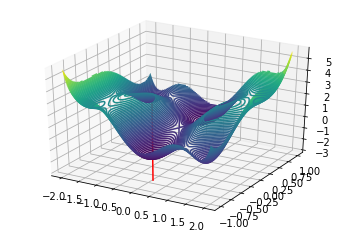

In [29]:
def camelback_f(params):
    x, y = params
    return (4 - 2.1 * np.power(x,2.) + np.power(x,4.) / 3) * np.power(x,2) + x * y + (4*np.power(y,2)-4)*np.power(y,2)

ax = plt.axes(projection='3d')
density = 100
x = np.linspace(-2,2,density)
y = np.linspace(-1,1,density)
X, Y = np.meshgrid(x, y)
Z = camelback_f((X, Y))
ax.contour3D(X, Y, Z, 100)

density_search = 1000
x_lim = np.random.uniform(-2, 2, density_search)
y_lim = np.random.uniform(-1, 1, density_search)

solutions = [optimize.minimize(camelback_f, (x,y)) for x,y in zip(x_lim,y_lim)]
idx = np.argmin([solution.fun for solution in solutions])
solution = solutions[idx]
print(solution)

ax.plot((solution.x[0],solution.x[0]),(solution.x[1],solution.x[1]), (solution.fun-2,solution.fun+6), color = 'r' )
plt.show()

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

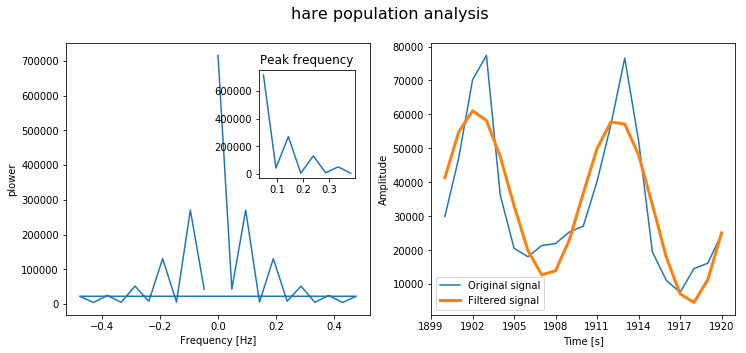

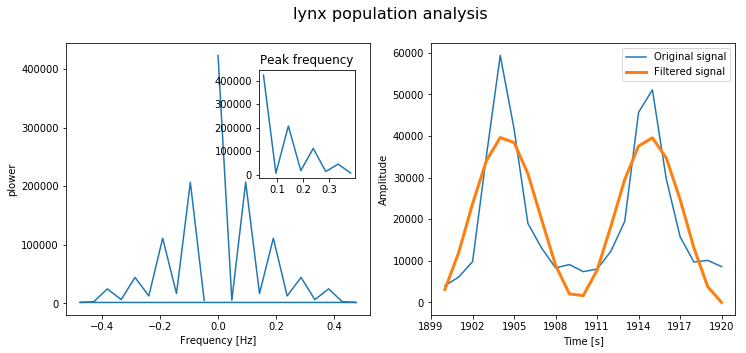

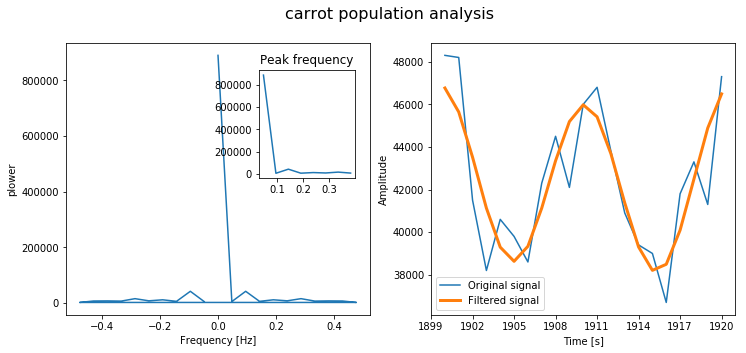

In [32]:
import pandas as pd
from scipy import fftpack
import numpy as np 
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator

data = pd.read_csv('populations.txt', sep="\t")
names = ['hare', 'lynx', 'carrot']

for name in names:
    sig = data[name]

    # The FFT of the signal
    sig_fft = fftpack.fft(sig)

    # And the power (sig_fft is of complex dtype)
    power = np.abs(sig_fft)
    
    # The corresponding frequencies
    sample_freq = fftpack.fftfreq(sig.size, d=1)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    fig.suptitle("{} population analysis".format(name), fontsize=16)
    # Plot the FFT power
    ax[0].plot(sample_freq, power)
    ax[0].set_xlabel('Frequency [Hz]')
    ax[0].set_ylabel('plower')

    # Find the peak frequency: we can focus on only the positive frequencies
    pos_mask = np.where(sample_freq > 0)
    freqs = sample_freq[pos_mask]
    peak_freq = freqs[power[pos_mask].argmax()]


    # An inner plot to show the peak frequency
    axes = inset_axes(ax[0], 
                    width="90%", # width = 30% of parent_bbox
                    height=1.5, # height : 1 inch
                    loc=1,
                    bbox_to_anchor=(0.6, 0.4, 0.35, 0.5),
                   bbox_transform=ax[0].transAxes,
                   borderpad=0,
                   )

    axes.set_title('Peak frequency')
    axes.plot(freqs[:8], power[:8])

    high_freq_fft = sig_fft.copy()
    high_freq_fft[np.abs(sample_freq) > peak_freq] = 0
    filtered_sig = fftpack.ifft(high_freq_fft)

    #plt.figure(figsize=(6, 5))
    ax[1].plot(data['# year'], sig, label='Original signal')
    ax[1].plot(data['# year'], filtered_sig, linewidth=3, label='Filtered signal')
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('Amplitude')
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

    ax[1].legend(loc='best')

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

In [22]:
import pylab
from scipy import fftpack
im = pylab.imread("moonlanding.png")
fft = fftpack.fft2(im)

/home/simone/anaconda3/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


/home/simone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in power
  """


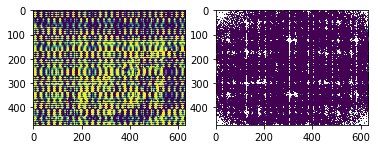

In [23]:
plt.figure(5)
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(abs(fft)**20)
plt.show()

<IPython.core.display.Javascript object>


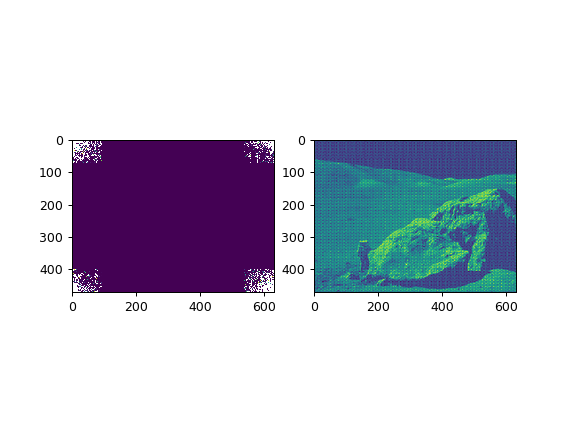

/home/simone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in power
  del sys.path[0]


In [12]:
keep_fraction = 0.15

fft[int(fft.shape[0]*keep_fraction):int(fft.shape[0]*(1-keep_fraction))] = 0

# Similarly with the columns:
fft[:, int(fft.shape[1]*keep_fraction):int(fft.shape[1]*(1-keep_fraction))] = 0

reconstructed = fftpack.ifft2(fft).real

plt.figure()
plt.subplot(1,2,1)
plt.imshow(abs(fft)**20)
plt.subplot(1,2,2)
plt.imshow(reconstructed)
plt.show()